In [27]:
import numpy as np
import matplotlib.pyplot as plt
import time
import tqdm

In [28]:
def Kuramoto_Delays_Run_AAL(C, D, f, K, MD):
    ############################%%%#
    #
    # Function to run simulations of coupled systems using the
    # KURAMOTO MODEL OF COUPLED OSCILLATORS WITH TIME DELAYS
    #
    # - Each node is represented by a Phase Oscillator
    # - with Natural Frequency f
    # - coupled according to a  connectivity matrix C
    # - with a distance matrix D (scaled to delays by the mean delay MD)
    #
    # All units in Seconds, Meters, Hz
    #
    # Simulation code written in Matlab by Joana Cabral,
    # January 2019, joana.cabral@psych.ox.ac.uk
    # 
    # Adapted to Python by Laurent Perrinet Jan 2019
    #
    ##############%%%%%#

    # MODEL PARAMETERS

    # # Define simulation Parameters
    # f=40 # Node natural frequency in Hz (i.e. f=40))
    # MD=0.02 # Mean Delay in seconds (i.e. MD=0.01)
    # K=5;
    dt = 1.e-4 # Resolution of model integration in seconds (i.e. dt=1e-4)
    tmax = 0.5 # Total simulation time in seconds
    t_prev = 0. # Total preview time in seconds
    dt_save = 2.e-3 # Resolution of saved simulations in seconds
    noise = 0

    # Normalize parameters
    N = C.shape[0] # Number of units
    Omegas = 2*np.pi*f*np.ones(N)*dt # Frequency of all units in radians/second
    kC = K*C*dt # Scale matrix C with 'K' and 'dt' to avoid doing it at each step
    dsig = np.sqrt(dt)*noise # normalize std of noise with dt

    # Set a matrix of Delays containing the number of time-steps between nodes
    # Delays are integer numbers, so make sure the dt is much smaller than the
    # smallest delay.
    if MD==0:
        Delays = np.zeros_like(C) # Set all delays to 0.
    else:
        Delays = D / D[C>0].mean() * MD / dt
        Delays = Delays.astype(np.int)

    Delays[C==0] = 0.

    Max_History = np.max(Delays.ravel()) + 1

    # Revert the Delays matrix such that it contains the index of the History
    # that we need to retrieve at each dt
    Delays = Max_History - Delays


    # Initialization

    # History of Phases is needed at dt resolution for as long as the longest
    # delay. The system is initialized all desinchronized and uncoupled
    # oscillating at their natural frequencies

    Phases_History = 2*np.pi*np.random.rand(N, Max_History)
    Phases_History += Omegas[:, None] #* np.ones(N, Max_History)#*np.arange(Max_History)[:, None]
    Phases_History = np.mod(Phases_History, 2*np.pi) # all values between 0 and 2pi

    # This History matrix will be continuously updated (sliding history).
    # figure plot(sin(Phases_History'))   # To see the History

    # Simulated activity will be saved only at dt_save resolution
    Phases_Save = np.zeros((N, int(tmax/dt_save)))
    sumz = np.zeros(N)

    # Run simulations
    print('Now running for K=',  K,  ', mean Delay = ', MD*1e3, 'ms')
    print('Max_History=',  Max_History, 'steps')


    
    tic = time.time() # to count the time of each run
    nt = 0
    
    for i_t in tqdm.tqdm(range(int((t_prev+tmax)/dt))):
        # We only start saving after t_prev
        Phase_Now = Phases_History[:, -1] # The last collumn of Z is 'now'
        # Input from coupled units
        for n in range(N):
            sumzn = 0 # Intitalize total coupling received into node n
            for p in range(N):
                if kC[n, p]>0: # Calculate only input from connected nodes (faster)
                    phase = Phases_History[p, Delays[n, p]]-Phase_Now[n]
                    sumzn += kC[n,p] * np.sin(phase)
            sumz[n] = sumzn

        if MD>0: # Slide History only if the delays are >0
            Phases_History[:, :-2] = Phases_History[:, 1:-1]

        # Update the end of History with evolution in the last time step
        Phases_History[:, -1] = Phase_Now
        Phases_History[:, -1] += Omegas + sumz + dsig*np.random.randn(N)

        # Save dt_save resolution after t_prev
        if np.mod(i_t, int(dt_save/dt)) == 0 and i_t*dt>t_prev:
            Phases_Save[:, nt] = Phases_History[:, -1]
            nt += 1

    toc = time.time() - tic
    print('Finished, lasted %.3f ' % toc , ' secs for real %.3f ', t_prev+tmax , ' seconds')

    print('Simu speed ratio %.3f =' % (toc/(t_prev+tmax)), ' Realseconds/SimuSecond')

    return Phases_Save, dt_save


In [29]:
#####################%%%%%%
#
# Code to call simulations of a network model
# and visualize the results.
#
# Generates figure with:
# - timeseries, power spectra and phase order over time
# - matrices of coupling wights, distances and 'Functional Connectivity'
#
# Joana Cabral January 2019 joanacabral@med.uminho.pt
#
#     # Adapted to Python by Laurent Perrinet Jan 2019
#
#####################%%%%%%

# Define here the Network Spatial and Temporal structure

# Define the Structural Network as a NxN matrix
from scipy.io import loadmat
C = loadmat('./AAL_matrices.mat')['C']

# Number of coupled Units
N = C.shape[0]

# note: using the line below Normalizes the whole matrix by the mean
# of all non-diagonal elements is 1. 
# C=C/mean(C(ones(N)-eye(N)>0));
# here I do what you describe in the following line:
# Normalize such that the mean of all non-diagonal elements is 1.
C[np.diag(np.ones(N))==0] /= C[np.diag(np.ones(N))==0].mean()

# Distance between areas
D = loadmat('./AAL_matrices.mat')['D']
D /= 1000 # Distance matrix in meters

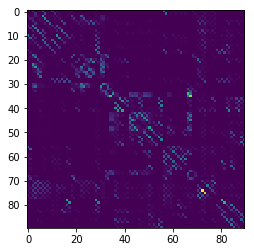

In [30]:
plt.imshow(C)

In [31]:
# Define here the parameters of the network model to be manipulated

# Node natural frequency in Hz
f = 40    # (i.e. f=40)):

# Mean Delay in seconds
MD = 0.02 # (i.e. MD = 0.01)

# Global Coupling strength
K = 5 #


# Process the simulated data and generate figures

# Call here the function of the Network Model
#from Kuramoto_Delays_Run import Kuramoto_Delays_Run_AAL
Phases_Save, dt_save = Kuramoto_Delays_Run_AAL(C, D, f, K, MD)




  0%|          | 5/5000 [00:00<02:00, 41.59it/s]

Now running for K= 5 , mean Delay =  20.0 ms
Max_History= 498 steps


100%|██████████| 5000/5000 [01:38<00:00, 51.01it/s]

Finished, lasted 98.027   secs for real %.3f  0.5  seconds
Simu speed ratio 196.053 =  Realseconds/SimuSecond


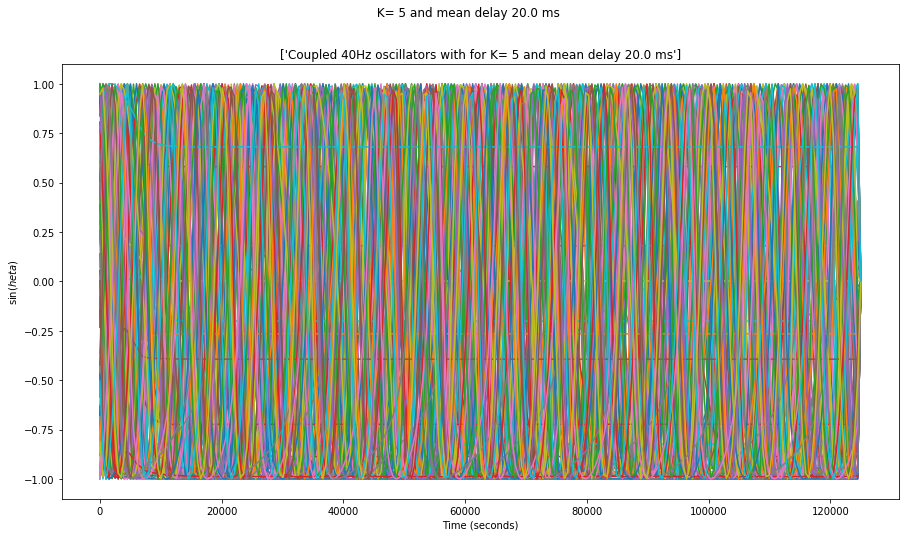

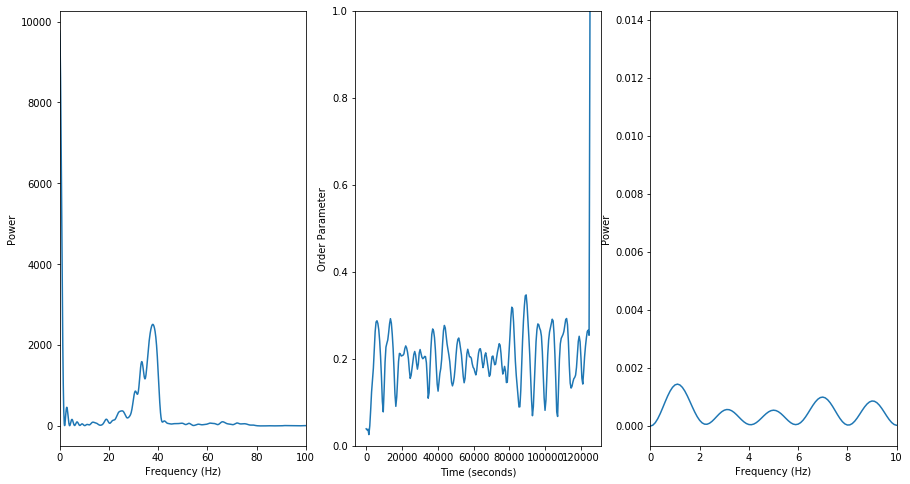

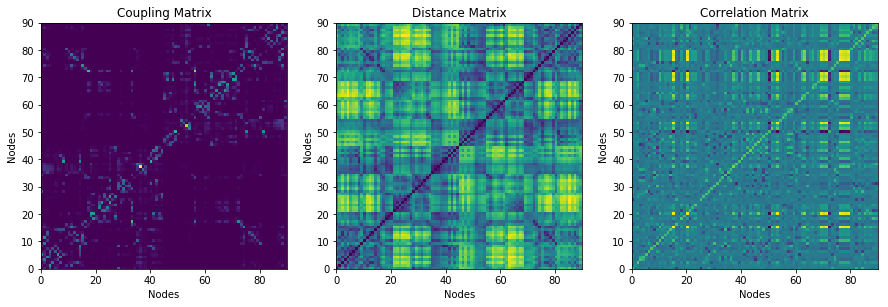

In [32]:

N_time = Phases_Save.shape[1] 
tmax = N_time / dt_save
time = np.linspace(0, tmax, N_time)

# Plot simulated time series
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
ax.plot(time, np.sin(Phases_Save.T))
ax.set_xlabel('Time (seconds)')
ax.set_ylabel('sin($\theta$)')
ax.set_title(['Coupled ' + str(f) + 'Hz oscillators with for K= ' + str(K) + ' and mean delay ' + str(MD*1e3) + ' ms'])
fig.suptitle(' K= ' + str(K) + ' and mean delay ' + str(MD*1e3) + ' ms')
         
# Power Spectrum
fig, axs = plt.subplots(1, 3, figsize=(15, 8))
fbins = 5000
freqZ = np.arange(fbins)/(dt_save*fbins)
ind100Hz = np.argmin(freqZ==100)
Fourier = np.fft.fft(np.sin(Phases_Save), n=fbins, axis=-1)
PSD = np.abs(Fourier)**2
ax = axs[0]
ax.plot(freqZ[:fbins//2], PSD[:, :fbins//2].mean(axis=0))
ax.set_xlim([0, 100])
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power')

# Plot the Order Parameter over time
ax = axs[1]
OP = np.abs(np.mean(np.exp(1j*Phases_Save), axis=0))
ax.plot(time, OP)
ax.set_ylim([0, 1])
ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Order Parameter')

# Power Spectrum of the Order Parameter
ax = axs[2]
Fourier = np.fft.fft(OP-OP.mean(), n=fbins, axis=0)
PSD = np.abs(Fourier)**2
PSD = PSD[:fbins//2]
PSD /= PSD.sum()
ax.plot(freqZ[:fbins//2], PSD)
ax.set_xlim([0, 10])
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power')

# Plot Connectivity and Distance Matrices and mean Phase Coherence

# Change the order of units for visualization (optional)
Order = np.arange(0, N, 2) # This sorts the AAL areas into left and right hemispheres
Order = np.hstack((Order, np.arange(N-1, 0, -2)))

fig, axs = plt.subplots(1, 3, figsize=(15, 8))
ax = axs[0]
# colormap(jet)
ax.pcolormesh(C[Order, :][:, Order])

ax.set_xlabel('Nodes')
ax.set_ylabel('Nodes')
ax.set_title('Coupling Matrix')
ax.axis('square')
#plt.colorbar()

ax = axs[1]
ax.pcolormesh(D[Order, :][:, Order])
ax.set_xlabel('Nodes')
ax.set_ylabel('Nodes')
ax.set_title('Distance Matrix')
ax.axis('square')
#plt.colorbar()

ax = axs[2]
X = np.sin(Phases_Save)
FC = (X[:, None, :] * X[None, :, :]).mean(axis=-1)
ax.pcolormesh(FC[Order, :][:, Order])
ax.set_xlabel('Nodes')
ax.set_ylabel('Nodes')
ax.set_title('Correlation Matrix')
ax.axis('square');
#plt.colorbar()